In [4]:
# just locally running the notebook found at https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
# !pip install git+https://github.com/openai/glide-text2im

In [5]:
from PIL import Image
from IPython.display import display
import torch as th
import os

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print("torch version", th.__version__)
print(th.cuda.memory_summary())

torch version 1.9.0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |      

In [7]:
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [8]:
# has_cuda = False
has_cuda = th.cuda.is_available() # This sporadically me a CUDA: Out of Memory Error when True
device = th.device('cuda' if has_cuda else 'cpu')
print(device)

cuda


In [9]:
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100'
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [10]:
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [11]:
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     806 MB |    2293 MB |    2293 MB |    1486 MB |
|       from large pool |     765 MB |    2226 MB |    2226 MB |    1461 MB |
|       from small pool |      40 MB |      66 MB |      66 MB |      25 MB |
|---------------------------------------------------------------------------|
| Active memory         |     806 MB |    2293 MB |    2293 MB |    1486 MB |
|       from large pool |     765 MB |    2226 MB |    2226 MB |

In [12]:
th.cuda.empty_cache()
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     806 MB |    2293 MB |    2293 MB |    1486 MB |
|       from large pool |     765 MB |    2226 MB |    2226 MB |    1461 MB |
|       from small pool |      40 MB |      66 MB |      66 MB |      25 MB |
|---------------------------------------------------------------------------|
| Active memory         |     806 MB |    2293 MB |    2293 MB |    1486 MB |
|       from large pool |     765 MB |    2226 MB |    2226 MB |

In [13]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling

In [14]:
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
# getting a GPU OOM unless cache is cleared
# th.cuda.empty_cache()
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [15]:
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1648 MB |    3184 MB |    4671 MB |    3022 MB |
|       from large pool |    1570 MB |    3081 MB |    4542 MB |    2972 MB |
|       from small pool |      78 MB |     102 MB |     128 MB |      50 MB |
|---------------------------------------------------------------------------|
| Active memory         |    1648 MB |    3184 MB |    4671 MB |    3022 MB |
|       from large pool |    1570 MB |    3081 MB |    4542 MB |

In [16]:
def show_images(batch: th.Tensor):
    """Display a batch of images inline."""
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [29]:
# Sampling parameters
prompt = "cartoon chimpanzee playing slot machines"
batch_size = 3
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# a value of 1.0 is sharper but sometimes results in grainy artifacts.
upsample_temp = 0.997

In [30]:
## Sample from the base model

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])


In [31]:

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask( [], options['text_ctx'])

print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1651 MB |    3184 MB |    1590 GB |    1588 GB |
|       from large pool |    1572 MB |    3081 MB |    1556 GB |    1554 GB |
|       from small pool |      78 MB |     102 MB |      34 GB |      34 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1651 MB |    3184 MB |    1590 GB |    1588 GB |
|       from large pool |    1572 MB |    3081 MB |    1556 GB |

In [32]:

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens = th.tensor([tokens] * batch_size + [uncond_tokens] * batch_size, device = device),
    mask = th.tensor([mask] * batch_size + [uncond_mask] * batch_size, device = device, dtype=th.bool),
)

print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1651 MB |    3184 MB |    1590 GB |    1588 GB |
|       from large pool |    1572 MB |    3081 MB |    1556 GB |    1554 GB |
|       from small pool |      78 MB |     102 MB |      34 GB |      34 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1651 MB |    3184 MB |    1590 GB |    1588 GB |
|       from large pool |    1572 MB |    3081 MB |    1556 GB |

In [33]:
th.cuda.empty_cache()

In [34]:
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1651 MB |    3184 MB |    1590 GB |    1588 GB |
|       from large pool |    1572 MB |    3081 MB |    1556 GB |    1554 GB |
|       from small pool |      78 MB |     102 MB |      34 GB |      34 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1651 MB |    3184 MB |    1590 GB |    1588 GB |
|       from large pool |    1572 MB |    3081 MB |    1556 GB |

In [35]:

# Create a classifier-free guidance sampling function

def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) //2]
    combined = th.cat([half, half], dim = 0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim = 0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim = 0)
    return th.cat([eps, rest], dim = 1)

# Sample from the base model
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()


  0%|          | 0/100 [00:00<?, ?it/s]

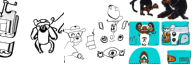

In [36]:

show_images(samples)

In [37]:
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1651 MB |    3184 MB |    2590 GB |    2588 GB |
|       from large pool |    1572 MB |    3081 MB |    2529 GB |    2527 GB |
|       from small pool |      78 MB |     102 MB |      61 GB |      60 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1651 MB |    3184 MB |    2590 GB |    2588 GB |
|       from large pool |    1572 MB |    3081 MB |    2529 GB |

In [38]:
# Upsample the 64 x 64 samples

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(tokens, options_up['text_ctx'])

  0%|          | 0/27 [00:00<?, ?it/s]

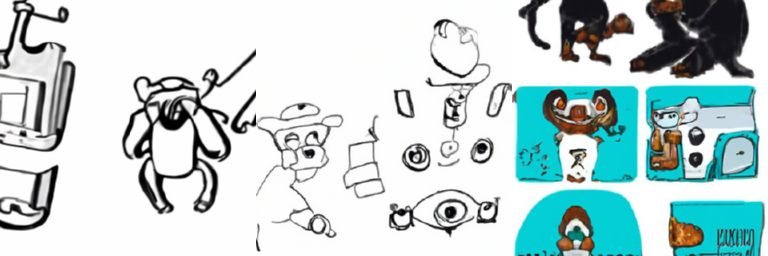

In [39]:
up_model_kwargs = dict (
    # Low-res image to upsample
    low_res = ((samples+1)*127.5).round()/127.5 - 1,
    tokens = th.tensor([tokens] * batch_size, device = device),
    mask = th.tensor([mask] * batch_size, device = device, dtype=th.bool)
)

# Sample from the base model
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise = th.randn(up_shape, device = device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=up_model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

show_images(up_samples)

In [40]:
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1651 MB |    3184 MB |    3176 GB |    3174 GB |
|       from large pool |    1572 MB |    3081 MB |    3107 GB |    3106 GB |
|       from small pool |      78 MB |     102 MB |      68 GB |      68 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1651 MB |    3184 MB |    3176 GB |    3174 GB |
|       from large pool |    1572 MB |    3081 MB |    3107 GB |